CIS 678 Challenge 3
===================
### MNIST Classification, Wyatt Barber

I worked with Abby on this challenge, we mostly did our own programming, and exchanged ideas for model architecture, training, and preprocessing. She was able to get her R implementation to work well while I was struggling with some bugs in my C++ implementation, so I used her work as a guide to check if my implementation was working right. 

This notebook uses a C++ backend using Eigen and OpenMP for linear algebra and parallelization. The python module neuralnet is created from this backend uing PyBind11.

The C++ source defines a class Network, which implements the forward and backward propatgation algorithms.

The network class assembles a list of Layer objects, each one having a derived type for its specific activation function. Network handled feeding data forwards and backwards through each layer. The forward pass and backwards pass is specific to each layer. All layer types are initialized with a uniform distribution, scaled by the square root of 2 over the size of the input to that layer (che initialization). I added this initialization after seeing that Abby had success with it, and my models were not converging. I found that other initialization methods (normal distribution with various means and deviations, uniform without scaling) resulted in models that do not converge. I didn't expect the initialization to have such a pronounced impact on the results. 

In [ ]:
# Import C++ perceptron implementation
import neuralnet as nn
# Import other libraries
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

In [2]:
# Load training data
TRAIN_IN = np.genfromtxt('data/mnist_train.csv', delimiter=',', skip_header=1)

TRAIN_OUT = np.genfromtxt('data/mnist_train_targets.csv', delimiter=',', skip_header=1, dtype=int)

TEST_IN = np.genfromtxt('data/mnist_test.csv', delimiter=',', skip_header=1)

# Define a function to format and save data for submission
def save_result(data, filename):
    if not ('.csv' in filename):
            filename += '.csv'

    # Format results in the format kaggle wants 
    results_out = [["\"Id\"","\"Expected\""]]
    for i in range(0, len(data)):
        results_out.append([f"\"{i+1}\"", f"\"{int(data[i])}\""])


    np.savetxt(F"results/{filename}", results_out, delimiter=',', fmt="%s")


Start with simple scaling to a 0 to 1 scale for preprocessing. I've seen that networks trained on the raw data don't converge well.

In [3]:
for i in range(TRAIN_IN.shape[1]):
    TRAIN_IN[:,i] /= 255
for i in range(TEST_IN.shape[1]):
    TEST_IN[:,i] /= 255

Starting Model
--------------
Train a multistate classifier with a guess at the layer count and sizes. Use ReLU for hidden layers and sigmoid for output. The number and size of hidden layers are based on what Abby found worked well for her, I'm using the same parameters her to make sure any issues are with my implementation, not my model parameters.

In [26]:
dims = [200, 60, 10]
funcs = [nn.ActivationFunctions.ReLU] * len(dims)

model = nn.Network([TRAIN_IN.shape[0], *dims,  10],    [*funcs, nn.ActivationFunctions.SoftMax])
errors = model.train(
    [TRAIN_IN[:,i] for i in range(TRAIN_IN.shape[1])], 
    TRAIN_OUT, 
    0.01, 10
)

Display a plot of the error as backpropagation progresses, to verify that the model is converging

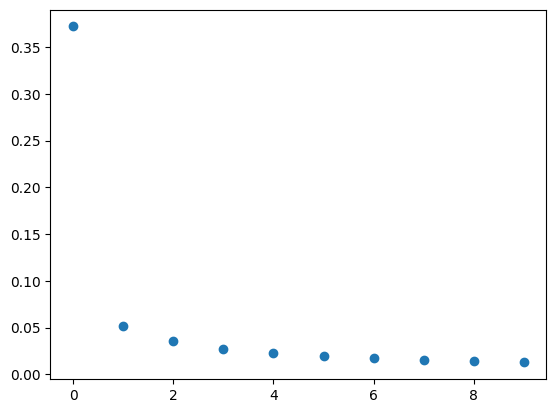

In [27]:
plt.scatter(range(len(errors)), errors)
results = []
for i in range(TEST_IN.shape[1]):
    y = model.forward(TEST_IN[:,i])
    results.append(np.argmax(y))

save_result(results, f"softmax_{'_'.join([str(d) for d in dims])}")

The model does converge, and reports above 90% accuracy on kaggle. Since the basic implementation works, now I'll move on to cross validation.

Cross Validation of Layer Count and Size
----------------------------------------
The test_layers takes a list of lists, with each element being the size of one layer in the network, and another list of lists specifying activation functions. Each list must be the same length, the ith item in the layer size list is paired with the ith item in the activation function to construct the ith model to test.

It also takes input and target data, rate, and epochs parameters like the train function. The final two parameters are the percentage of data to holdout for testing, and the number of times to redo the test on new randomly shuffled train/test data.

OpenMP is used to paralellize testing of each model in the list.

In [6]:
# Try some cross validation of different network depths
dims = [
    [50],
    [70],
    [70, 20],
    [30, 30],
    [300, 50, 20],
    [500, 200, 50],
    [700, 500, 300, 30]
]
# Generate activation function lists and output dimension
funcs = []
for i in range(len(dims)):
    f = [nn.ActivationFunctions.ReLU] * (len(dims[i]))
    f.append(nn.ActivationFunctions.SoftMax)
    funcs.append(f)
    dims[i].append(10)
    dims[i] = [TRAIN_IN.shape[0], *dims[i]]
# Test models
test_res = nn.test_layers(dims, funcs,
                        TRAIN_IN, TRAIN_OUT, 
                        0.05, 3, # 5% test density, 3 tests per model
                        0.01, 10 # 0.01 learning rate over 10 epochs
)
# test_res = []
# for i in range(len(dims)):
#     test_res.append(nn.test(dims[i], funcs[i], TRAIN_IN, TRAIN_OUT, 0.05, 3, 0.01, 10))


([<matplotlib.axis.XTick at 0x1715403c450>,
 [Text(0, 0, '[784,50,10]'),
  Text(1, 0, '[784,70,10]'),
  Text(2, 0, '[784,70,20,10]'),
  Text(3, 0, '[784,30,30,10]'),
  Text(4, 0, '[784,300,50,20,10]'),
  Text(5, 0, '[784,500,200,50,10]'),
  Text(6, 0, '[784,700,500,300,30,10]')])

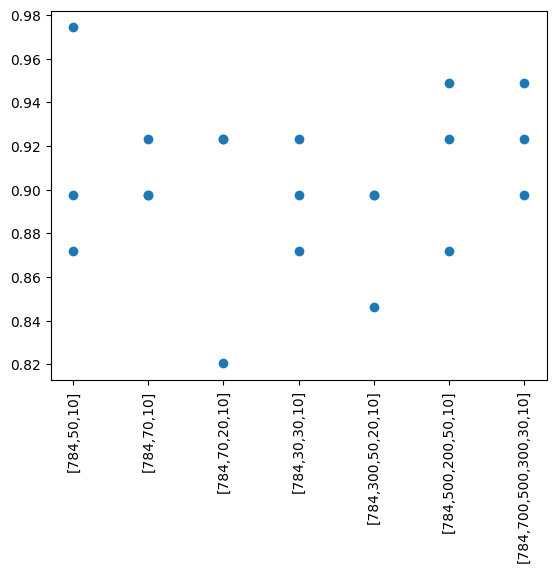

In [7]:
# Format and display results
x = []
y = []
for i in range(len(test_res)):
    x.extend([i]*len(test_res[i]))
    y.extend(test_res[i])
dim_txt = []
for d in dims:
    dim_txt.append(f'[{",".join([str(di) for di in d])}]')
plt.scatter(x,y)
plt.xticks(ticks=range(len(test_res)), labels=dim_txt, rotation='vertical')

Unfortunately my function does not seem to work. It runs a lot faster than I think it should (faster than if would take to train and test one of the larger models in the list one time), the results don't show much of a trend in error vs model complexity, and the results don't track what kaggle reports.

In kaggle submissions my best results were:
- Hidden layers of size 200, 60, 10, rate 0.01, 10 epochs: 0.974
- Hidden layers of size 700, 600, 400, 250, 100, 20, rate 0.01, 10 epochs: 0.978

The larger model had only slight gain over the smaller, which could just have been variation in the random initialization. Without my cross validation function I'll use these two models as a start for further tuning. Now I'll try a couple different preprocessing methods, with the goal of surpressing noise in the training data to prevent overfitting. 

In [8]:
# Binary input, where any pixel that is non-zero is set to one. May help to mask slight variations in shading of a digit
TRAIN_IN_BIN = np.copy(TRAIN_IN)
TRAIN_IN_BIN[TRAIN_IN_BIN > 0] = 1.0
# Average with neighboring pixels. Averaging over flattened array for simplicity, which should introduce vertical or horizontal 'smearing' with some wrapping at the edges
TRAIN_IN_AVG = np.zeros(TRAIN_IN.shape)
for i in range(TRAIN_IN.shape[1]):
    for j in range(TRAIN_IN.shape[0]):
        low = max(0, j-4)
        high = min(j+4, TRAIN_IN.shape[0]-1)
        TRAIN_IN_AVG[j,i] = np.mean(TRAIN_IN[low:high, i])

# Define a function to simplify generating results 
def gen_results(model, data):
    results = []
    for i in range(data.shape[1]):
        y = model.forward(data[:,i])
        results.append(np.argmax(y))
    return results


Train a model on each of the datasets. Use same number/size of hidden layers and activation functions for each. 

In [9]:
dims = [700]
funcs = [nn.ActivationFunctions.ReLU] * len(dims)

model_bin = nn.Network([TRAIN_IN.shape[0], *dims,  10],    [*funcs, nn.ActivationFunctions.SoftMax])
model_bin.train([TRAIN_IN_BIN[:,i] for i in range(TRAIN_IN_BIN.shape[1])], TRAIN_OUT, 0.01, 3)
save_result(gen_results(model_bin, TEST_IN), "binary_data")

model_avg = nn.Network([TRAIN_IN.shape[0], *dims,  10],    [*funcs, nn.ActivationFunctions.SoftMax])
model_avg.train([TRAIN_IN_AVG[:,i] for i in range(TRAIN_IN_AVG.shape[1])], TRAIN_OUT, 0.01, 3)
save_result(gen_results(model_avg, TEST_IN), "averaged_data")

Both methods performed OK, but the binary image input was better than averaged with a score of 0.961 vs 0.89233. I'll try this with my best performing model from above to see how it does.

In [21]:
dims = [700, 600, 400, 250, 100, 20]
    
funcs = [nn.ActivationFunctions.ReLU] * len(dims)
    
funcs = [nn.ActivationFunctions.ReLU] * (len(dims)-1)

model = nn.Network([*dims,  10],    [*funcs, nn.ActivationFunctions.SoftMax])

model.train([TRAIN_IN_BIN[:,i] for i in range(TRAIN_IN_BIN.shape[1])], TRAIN_OUT, 0.01, 10)

TEST_IN_BIN = np.copy(TEST_IN)
TEST_IN_BIN[TEST_IN_BIN > 0] = 1.0
save_result(gen_results(model, TEST_IN_BIN), "binary_data_deep")

That preprocessing doesn't perform very different from the basic scaled data, it actually seems to perform slightly worst. I'll try training a model further, using a lower learning rate for epochs beyond 10, to see if "fine tuning" a model gets better results. 

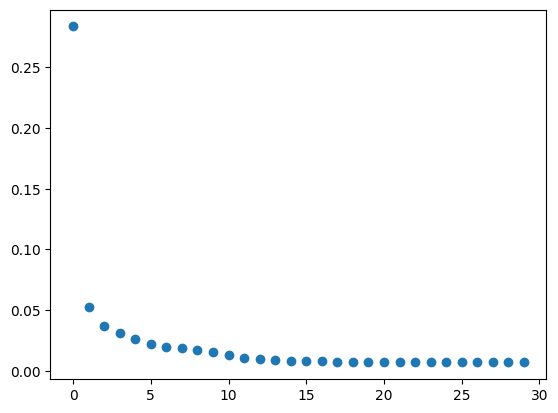

In [23]:
dims = [700, 600, 400, 250, 100, 20]
    
funcs = [nn.ActivationFunctions.ReLU] * len(dims)

model = nn.Network([TRAIN_IN.shape[0], *dims,  10],    [*funcs, nn.ActivationFunctions.SoftMax])

errors_1 = model.train([TRAIN_IN[:,i] for i in range(TRAIN_IN.shape[1])], TRAIN_OUT, 0.01, 10)
errors_2 = model.train([TRAIN_IN[:,i] for i in range(TRAIN_IN.shape[1])], TRAIN_OUT, 0.0001, 10)
errors_3 = model.train([TRAIN_IN[:,i] for i in range(TRAIN_IN.shape[1])], TRAIN_OUT, 0.000001, 10)

save_result(gen_results(model, TEST_IN), f"long_training_{'_'.join([str(d) for d in dims])}")

errors = [*errors_1, *errors_2, *errors_3]
plt.scatter(range(len(errors)), errors)

That also didn't havea significant impact, based on the plot and kaggle results.

Python Implementation
---------------------
While I was struggling with models not converging, I made this python version to see if I could get it to work better. It doesn't converge correctly, and I got the C++ version to perform better with che initialization so I didn't put more into this version.

In [10]:
def ReLU(x):
    out = x
    out[x < 0] = 0
    return out

def GradReLU(fx, error):
    fx[fx > 0] = 1.0
    return fx * error

def Sigmoid(x):
    out = np.zeros(x.size)
    for i in range(x.size):
        if x[i] > -700:
            out[i] = 1.0 / (1.0 + np.exp(-x[i]))
        else:
            out[i] = 0.000001
    return out

def GradSigmoid(fx, error):
    out = fx * (np.ones(fx.size) - fx)
    return out * error

def SoftMax(x):
    out = np.zeros(x.shape)
    for i in range(x.size):
        if x[i] < 700:
            out[i] = np.exp(x[i])
        else:
            out[i] = 1e300
    return out / (np.sum(out) + 0.000001)

def GradSoftMax(fx, error):
    d = np.zeros(fx.size)
    for i in range(fx.size):
        kd = np.zeros(fx.size)
        kd[i] = 1.0
        d[i] = np.dot(error, fx[i] * (kd - fx))
    return d

In [11]:
Nh1 = 200
Nh2 = 60
Nh3 = 20

# Randomly initiaize weights, initialize biases with zero
W1 = np.random.uniform(low= -np.sqrt(TRAIN_IN.shape[0]*Nh1), high=np.sqrt(TRAIN_IN.shape[0]*Nh1), size=(TRAIN_IN.shape[0], Nh1))
W2 = np.random.uniform(low= -np.sqrt(Nh1*Nh2), high=np.sqrt(Nh1*Nh2), size=(Nh1, Nh2))
W3 = np.random.uniform(low= -np.sqrt(Nh2*Nh3), high=np.sqrt(Nh2*Nh3), size=(Nh2, Nh3))
W4 = np.random.uniform(low= -np.sqrt(Nh3*10), high=np.sqrt(Nh3*10), size=(Nh3, 10))
B1 = np.zeros(Nh1)
B2 = np.zeros(Nh2)
B3 = np.zeros(Nh3)
B4 = np.zeros(10)


# Train over 10 epochs
RATE = 0.01
errors = []
for epoch in range(10):
    err_ep = 0
    for i in range(TRAIN_IN.shape[1]):
        # Forward pass over this input value
        # Input layer
        z1 = np.matmul(W1.transpose(), TRAIN_IN[:,i]) + B1
        a1 = ReLU(z1)
        # First hidden layer
        z2 = np.matmul(W2.transpose(), a1) + B2
        a2 = ReLU(z2)
        # Second hidden layer
        z3 = np.matmul(W3.transpose(), a2) + B3
        a3 = ReLU(z3)
        # Output layer
        z4 = np.matmul(W4.transpose(), a3) + B4
        y = SoftMax(z4)

        # Now calculate the error
        if np.argmax(y) != TRAIN_OUT[i]:
            err_ep += 1.0 / TRAIN_IN.shape[1]
        target = np.zeros(10)
        target[TRAIN_OUT[i]] = 1.0
        eps = y - target       

        # Backpropagate error
        # Ouptut layer error
        d4 = GradSoftMax(y, eps)
        # Second hidden layer error
        d3 = GradReLU(a3, np.matmul(W4, d4))
        # First hidden layer error
        d2 = GradReLU(a2, np.matmul(W3, d3))
        # Input layer error
        d1 = GradReLU(a1, np.matmul(W2, d2))

        # Update model parameters
        for n in range(W1.shape[1]):
            W1[:,n] -= RATE * d1[n] * TRAIN_IN[:,i]
        B1 -= RATE * d1

        for n in range(W2.shape[1]):
            W2[:,n] -= RATE * d2[n] * a1
        B2 -= RATE * d2
        
        for n in range(W3.shape[1]):
            W3[:,n] -= RATE * d3[n] * a2
        B3 -= RATE * d3
        
        for n in range(W4.shape[1]):
            W4[:,n] -= RATE * d4[n] * a3
        B4 -= RATE * d4

    errors.append(err_ep)



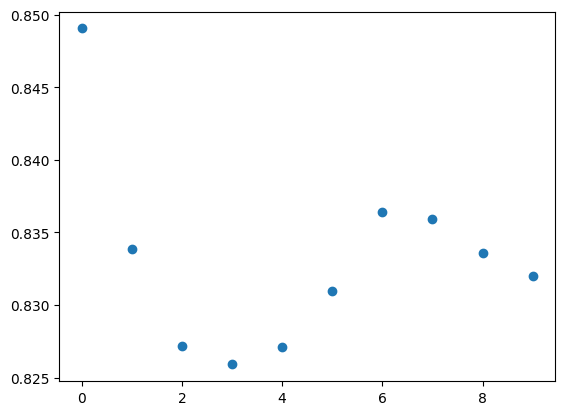

In [12]:
plt.scatter(range(len(errors)), errors)